# 3104 Assignment 1
### [30 Marks, 20%]

## Import libraries

In [1]:
from IPython.display import clear_output
!pip install scikit-learn
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install plotly

clear_output()

In [2]:
from IPython.display import Markdown
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore')
np.random.seed(42)

In [3]:
# Global variables
train_svm_models = False

## Load dataset

In [4]:
trainingset = np.loadtxt('training.csv', delimiter=',')
testingset = np.loadtxt('test.csv', delimiter=',')
trainingset

array([[ 70.,  80.,  82., ...,   0.,   0.,   0.],
       [151., 150., 147., ...,   0.,   0.,   0.],
       [231., 212., 156., ...,   0.,   0.,   0.],
       ...,
       [ 74.,  81.,  87., ...,   1.,   0.,   0.],
       [222., 227., 203., ...,   0.,   0.,   0.],
       [195., 199., 205., ...,   1.,   0.,   0.]])

## Split data

In [5]:
n_inputs = 2304 # images are 48 x 48
n_classes = 7 # 7 classes - as defined below
img_dim = 48 # each input image dimension, width and height are both 48

x_training = trainingset[:, 0:n_inputs] # Extract the first 2304 elements - the image
y_training = trainingset[:, n_inputs:n_inputs + n_classes] # Extract the last 7 elements - a one hot category encoding

x_testing = testingset[:, 0:n_inputs] # Extract the first 2304 elements - the image
y_testing = testingset[:, n_inputs:n_inputs + n_classes] # Extract the last 7 elements - a one hot category encoding

x_training = x_training.reshape(x_training.shape[0], 48, 48) # Make samples image shaped
x_testing = x_testing.reshape(x_testing.shape[0], 48, 48) # Make samples image shaped

In [6]:
def get_emotion(whichemotion):
    if whichemotion.shape[0] == 1:
        indx = whichemotion[0]
    else:
        indx = np.argmax(whichemotion)
    if indx == 0:
        return 'angry'
    elif indx == 1:
        return 'disgust'
    elif indx == 2:
        return 'fear'
    elif indx == 3:
        return 'happy'
    elif indx == 4:
        return 'sad'
    elif indx == 5:
        return 'surprise'
    elif indx == 6:
        return 'neutral'

X training shape (28709, 48, 48)
y training shape (28709, 7)
X testing shape (3589, 48, 48)
y testing shape (3589, 7)


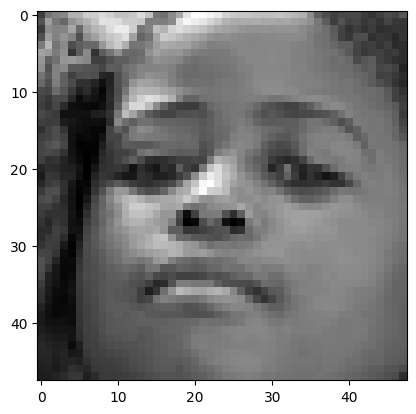

facial emotion: neutral


In [7]:
print("X training shape", x_training.shape)
print("y training shape", y_training.shape)

print("X testing shape", x_testing.shape)
print("y testing shape", y_testing.shape)

sampleindex = np.random.randint(0,1000)
sample = x_training[sampleindex, :]
sample = sample.reshape(48, 48)

plt.imshow(sample, cmap='gray')
plt.show()
print('facial emotion: %s' % get_emotion(y_training[sampleindex, :]))

# Part I : Happy or Sad

## For this part you will consider a binary classification problem - categorizing faces as happy or sad

[1 Mark] a. Sample from the data loaded above to include only the happy or sad cases

In [8]:
multiclass_emotions = {
    'angry': 0,
    'disgust': 1,
    'fear': 2,
    'happy': 3,
    'sad': 4,
    'surprise': 5,
    'neutral': 6
}

multiclass_emotions_inverse = {
    0: 'angry',
    1: 'disgust',
    2: 'fear',
    3: 'happy',
    4: 'sad',
    5: 'surprise',
    6: 'neutral'
}

emotion_color_map = {
    multiclass_emotions['angry']: 'r',
    multiclass_emotions['disgust']: 'g',
    multiclass_emotions['fear']: 'b',
    multiclass_emotions['happy']: 'm',
    multiclass_emotions['sad']: 'c',
    multiclass_emotions['surprise']: 'y',
    multiclass_emotions['neutral']: 'k'
}

HAPPY = 3
SAD = 4

In [9]:
emotion_columns = multiclass_emotions.keys()

def create_binary_classification_dataframe(dataset):
    """
    Create a datafrane from the dataset
    """

    # Create a dataframe with all the training data
    X_df = pd.DataFrame(dataset[:, :n_inputs])

    # Create a dataframe with all the emotion data
    y_df = pd.DataFrame(dataset[:, n_inputs:n_inputs + n_classes], columns=emotion_columns)

    # Concatenate X and y
    df = pd.concat([X_df, y_df], axis=1)

    # Filter only happy and sad
    df_sample = df[(y_df['happy'] == 1) | (y_df['sad'] == 1)].copy(deep=True)

    # Create emotion column, 1 for happy and 0 for sad
    df_sample['emotion'] = y_df[['happy', 'sad']].apply(lambda row: multiclass_emotions['happy'] if row['happy'] == 1 else multiclass_emotions['sad'], axis=1)

    # Remove all of the initial emotion columns
    df_sample.drop(emotion_columns, axis=1, inplace=True)

    return df_sample

# Create the dataframes for training and testing
df_binary_train = create_binary_classification_dataframe(trainingset)
df_binary_test = create_binary_classification_dataframe(testingset)

print("Binary train dataframe shape:", df_binary_train.shape)
print("Binary test dataframe shape:", df_binary_test.shape)
df_binary_train.head()

Binary train dataframe shape: (12045, 2305)
Binary test dataframe shape: (1548, 2305)


0     1     2      3      4      5      6      7      8      9  ...  \
3   24.0  32.0  36.0   30.0   32.0   23.0   19.0   20.0   30.0   41.0  ...   
6   20.0  17.0  19.0   21.0   25.0   38.0   42.0   42.0   46.0   54.0  ...   
7   77.0  78.0  79.0   79.0   78.0   75.0   60.0   55.0   47.0   48.0  ...   
8   85.0  84.0  90.0  121.0  101.0  102.0  133.0  153.0  153.0  169.0  ...   
14   4.0   2.0  13.0   41.0   56.0   62.0   67.0   87.0   95.0   62.0  ...   

     2295   2296   2297   2298   2299   2300   2301   2302   2303  emotion  
3   126.0  132.0  132.0  133.0  136.0  139.0  142.0  143.0  142.0        4  
6    36.0   68.0   91.0   85.0   93.0   97.0   99.0  107.0  118.0        4  
7   124.0  139.0  150.0  179.0  180.0  175.0  125.0   67.0   68.0        3  
8   151.0  111.0  106.0  102.0   99.0   89.0   58.0   73.0   84.0        3  
14   66.0   80.0   74.0   69.0   99.0   28.0    3.0    7.0   12.0        3  

[5 rows x 2305 columns]

In [10]:
# Check if the target variable is balanced
print("Train target variable distribution:")
binary_distribution_df = df_binary_train['emotion'].value_counts().reset_index()
binary_distribution_df['emotion'] = binary_distribution_df['emotion'].map(multiclass_emotions_inverse)
binary_distribution_df

Train target variable distribution:


emotion  count
0   happy   7215
1     sad   4830

[4 Marks] b. Apply PCA and LDA to represent the faces, display a sample of a few faces for each case. You may consider using one or both of these in the steps that follow if they are of any value (this is for you to decide).

Scale the data

In [11]:
def scale_dataframe(df_train: pd.DataFrame, df_test: pd.DataFrame) -> np.array:
    """
    Scale the data
    """

    # Create a standard scaler
    standar_scaler = StandardScaler()

    # Scale training data
    X_train_scaled = standar_scaler.fit_transform(df_train.drop('emotion', axis=1))

    # Scale testing data
    X_test_scaled = standar_scaler.transform(df_test.drop('emotion', axis=1))

    return X_train_scaled, X_test_scaled

X_train_binary_scaled, X_test_binary_scaled = scale_dataframe(df_binary_train, df_binary_test)
print("X train binary scaled", len(X_train_binary_scaled))
print("X test binary scaled", len(X_test_binary_scaled))

X train binary scaled 12045
X test binary scaled 1548


In [12]:
y_binary_train = df_binary_train['emotion']
y_binary_test = df_binary_test['emotion']
y_binary_train.shape, y_binary_test.shape

((12045,), (1548,))

PCA

In [13]:
def plot_face_annotation(X_train: np.array, y_train: np.array, component_1: np.array, component_2: np.array, n_faces: int):
    """
    Plot faces with annotations
    ---
    Args
    ...
    X_train: np.array - training data
    y_train: np.array - labels
    component_1: np.array - x values
    component_2: np.array - y values
    n_faces: int - number of faces to plot, default 10
    """
    
    # Get categories
    categories = np.unique(y_train)
    
    # Get 5 of items per category
    indexes = [np.random.choice(np.where(y_train == category)[0], n_faces) for category in categories]
    indexes = np.array(indexes).flatten()
    
    for index in indexes:

        emotion = y_train[index].item()
            
        # Configuration of bboxprops
        bboxprops = dict(
            boxstyle="round,pad=0.1",
            edgecolor=emotion_color_map.get(emotion),
            linewidth=2
        )

        # Create image box
        imagebox = OffsetImage(X_train[index].reshape(48, 48), zoom=0.5, cmap='gray')

        # Create annotation box
        ab = AnnotationBbox(
            offsetbox=imagebox,
            xy=(component_1[index], component_2[index]), # Position of the face X, Y
            bboxprops=bboxprops,
            frameon=True
        )

        # Add annotation box to the plot
        plt.gca().add_artist(ab)

        # Plot legends
        happy_legend = plt.Line2D([0], [0], color='m', label='Happy', marker='o')
        sad_legend = plt.Line2D([0], [0], color='c', label='Sad', marker='o')
        plt.legend(handles=[happy_legend, sad_legend])


In [14]:
def create_pca_2d(X_train: np.array, y_train: np.array, n_components: int, plot_chart: bool = False) -> None:
    """
    Create a PCA, plot the PCA and return the PCA instance
    ---
    Args
    ...
    X_train: np.array - training data
    y_train: np.array - labels
    n_components: int - number of components to use
    plot_chart: bool - plot the chart, default False
    """

    # Create a PCA instance and fit the data
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_train)

    component_1 = X_pca[:, 0]
    component_2 = X_pca[:, 1]
    c = pd.DataFrame(y_train).iloc[:,0].map(emotion_color_map).values

    # Plot the PCA
    if plot_chart:
        plt.figure(figsize=(14, 10))
        plt.scatter(
            component_1,
            component_2,
            c=c, 
            edgecolor='k',
            s=30,
            label='a'
        )
        plt.legend()
        plt.title('PCA')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plot_face_annotation(X_train, y_train, component_1, component_2, 10)
        plt.show()

    return pca

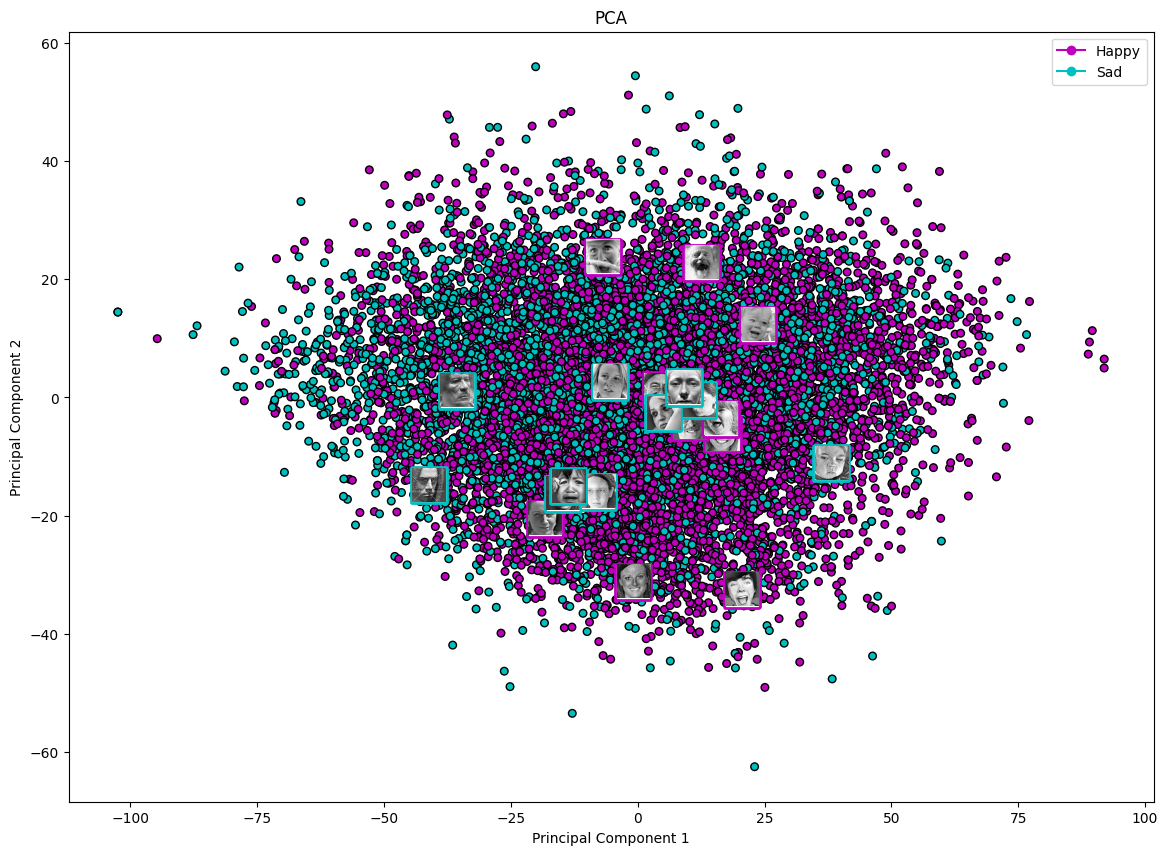

In [15]:
binary_pca_2_components = create_pca_2d(X_train_binary_scaled, y_binary_train.to_numpy(), 2, True)

LDA

In [16]:
def create_binary_lda(X_train: np.array, y_train: np.array, n_components: int) -> None:
    """
    Create a LDA, plot the result and return the LDA instance
    ---
    Args
    ...
    X_train: np.array - training data
    y_train: np.array - labels
    n_components: int - number of components
    """
    lda = LDA(n_components=n_components)

    # Transform the scaled data using LDA
    X_lda = lda.fit_transform(X_train, y_train)
    
    # Create the legend for the different emotions
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=emotion) for emotion, color in emotion_color_map.items()]

    component_1 = X_lda
    component_2 = np.array([0.02 if emotion == HAPPY else -0.015 for emotion in y_train]) # 0.02 is used to plot happy faces and -0.015 for sad faces
    y = np.zeros(len(X_lda))
    c = pd.DataFrame(y_train).iloc[:,0].map(emotion_color_map).values

    # Visualize the LDA result
    plt.figure(figsize=(16, 3))
    plt.scatter(x=component_1, y=y, c=c, cmap='viridis', edgecolor='k', s=40)
    plt.title('LDA')
    plt.colorbar()
    plt.legend(handles=handles, title="Emotion")
    plt.xlabel('Linear Discriminant 1')
    plot_face_annotation(X_train, y_train, component_1, component_2, 10)
    plt.show()

    return lda

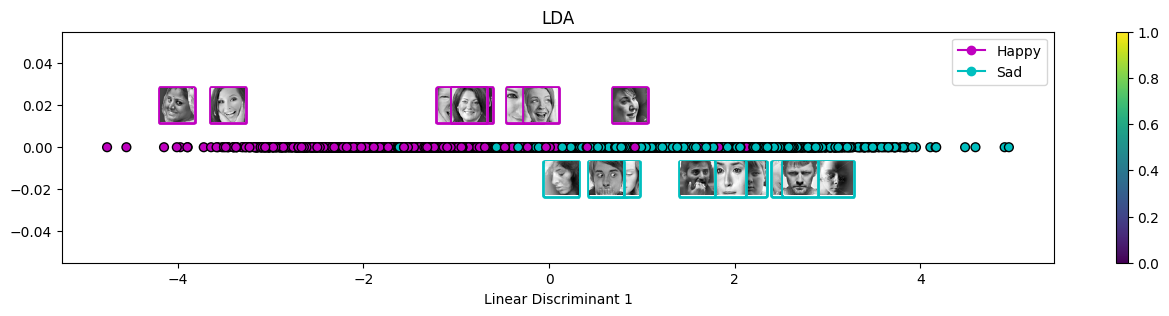

In [17]:
binary_lda_1_component = create_binary_lda(X_train_binary_scaled, y_binary_train.to_numpy(), 1)

[2 Marks] c. Apply naive Bayes to classify faces as happy or sad. Report your accuracy.

In [18]:
def describe_binary_confusion_matrix(model, X_train, y_train, title: str):
    """
    Create a confusion matrix and compute evaluation metrics.
    ---
    Args:
    model: object - model to evaluate
    X_train: np.array - training data
    y_train: np.array - training labels (3 for happy, 4 for sad)
    """

    # Predict values for training data
    y_pred = model.predict(X_train)

    # Calculate confusion matrix
    cm = confusion_matrix(y_train, y_pred, labels=[HAPPY, SAD])

    # Convert data to dataframe to plot
    cm_df = pd.DataFrame(cm,
                         index=['Real Happy', 'Real Sad'],
                         columns=['Predicted Happy', 'Predicted Sad'])

    # Plot confusion matrix
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm_df, cmap='Blues', fmt='g', annot=True, cbar=False)
    plt.title(f'Confusion Matrix {title}')
    plt.ylabel('Observed Label')
    plt.xlabel('Predicted Label')
    plt.show()

    TP = cm[1, 1]  # True Positives (sad correctly predicted as sad)
    TN = cm[0, 0]  # True Negatives (happy correctly predicted as happy)
    FP = cm[0, 1]  # False Positives (happy incorrectly predicted as sad)
    FN = cm[1, 0]  # False Negatives (sad incorrectly predicted as happy)

    # Compute precision
    precision = TP / (TP + FP)
    print(f"Precision: {precision:.4f}")

    # Compute recall
    recall = recall_score(y_train, y_pred, pos_label=4)
    print(f"Recall: {recall:.4f}")

    # Compute accuracy
    accuracy = accuracy_score(y_train, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # Compute F1 score
    f1 = 2 * (precision * recall) / (precision + recall)
    print(f"F1 score: {f1:.4f}")

In [19]:
def train_model(model: any, X_train: np.array, X_test: np.array, y_train: np.array, y_test: np.array) -> float:
    """
    Train a model and calculate the accuracy
    ---
    Args:
    ...
        model: any - model to train
        X_train:  training data
        X_test: np.array - testing data
        y_train: np.array - training labels
        y_test: np.array - testing labels
    """

    # Train the model
    model.fit(X_train, y_train)

    # Predict values
    y_pred_for_train = model.predict(X_train)
    y_pred_for_test = model.predict(X_test)

    # Calculate the accuracy
    train_accuracy = accuracy_score(y_train, y_pred_for_train)
    test_accuracy = accuracy_score(y_test, y_pred_for_test)
    print(f"Train accuracy: {train_accuracy * 100:.2f}%")
    print(f"Test accuracy: {test_accuracy * 100:.2f}%")

    return model, train_accuracy

In [20]:
def train_naive_bayes(X_train: np.array, X_test: np.array, y_train: np.array, y_test: np.array) -> float:
    """
    Create a Naive Bayes model
    ---
    Args:
    ...
        X_train:  training data
        X_test: np.array - testing data
        y_train: np.array - training labels
        y_test: np.array - testing labels
    """
    return train_model(GaussianNB(), X_train, X_test, y_train, y_test)

In [21]:
# Transform the data using PCA and LDA

# PCA
X_train_binary_pca = binary_pca_2_components.transform(X_train_binary_scaled)
X_test_binary_pca = binary_pca_2_components.transform(X_test_binary_scaled)

# LDA
X_train_binary_lda = binary_lda_1_component.transform(X_train_binary_scaled)
X_test_binary_lda = binary_lda_1_component.transform(X_test_binary_scaled)

In [22]:
# Scaled (Original)
print("Original")
binary_naive_bayes_original, acc = train_naive_bayes(X_train_binary_scaled, X_test_binary_scaled, y_binary_train, y_binary_test)

# PCA
print("\nPCA")
binary_naive_bayes_pca, acc = train_naive_bayes(X_train_binary_pca, X_test_binary_pca, y_binary_train, y_binary_test)

# LDA
print("\nLDA")
binary_naive_bayes_lda, acc = train_naive_bayes(X_train_binary_lda, X_test_binary_lda, y_binary_train, y_binary_test)

Original
Train accuracy: 60.12%
Test accuracy: 59.04%

PCA
Train accuracy: 61.33%
Test accuracy: 59.82%

LDA
Train accuracy: 79.17%
Test accuracy: 67.51%


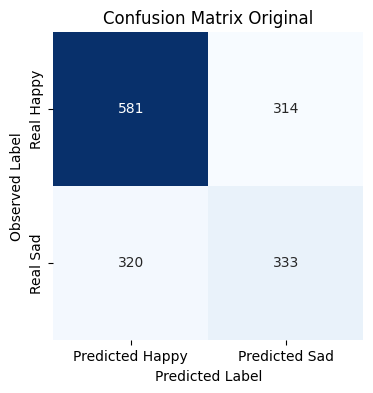

Precision: 0.5147
Recall: 0.5100
Accuracy: 0.5904
F1 score: 0.5123


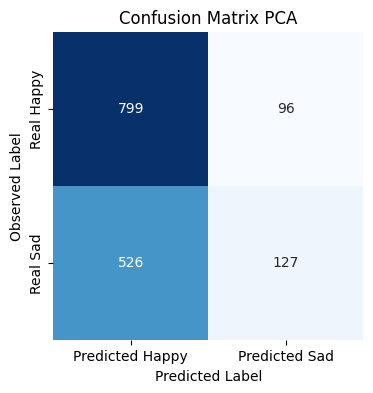

Precision: 0.5695
Recall: 0.1945
Accuracy: 0.5982
F1 score: 0.2900


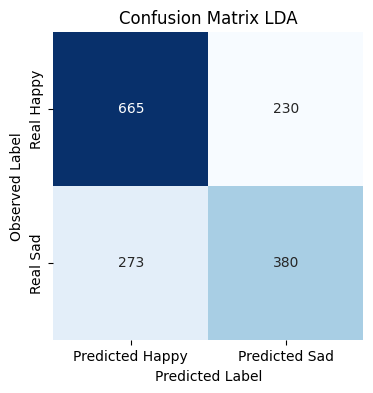

Precision: 0.6230
Recall: 0.5819
Accuracy: 0.6751
F1 score: 0.6017


In [57]:
# Describe confusion matrix for train
m1 = describe_binary_confusion_matrix(model=binary_naive_bayes_original, X_train=X_test_binary_scaled, y_train=y_binary_test, title='Original')
m2 = describe_binary_confusion_matrix(model=binary_naive_bayes_pca, X_train=X_test_binary_pca, y_train=y_binary_test, title='PCA')
m3 = describe_binary_confusion_matrix(model=binary_naive_bayes_lda, X_train=X_test_binary_lda, y_train=y_binary_test, title='LDA')

_Using PCA, the accuracy increate slightly to 59.82%, but LDA increase it to 67.51%_

- The accuracy for the models with and without PCA is similar; this result demonstrates that by using the PCA technique and reducing the number of features to two, we were able to retain the most essential information. The accuracy for the models with and without PCA is similar. This result is relevant as we always want fewer features and remove noise or irrelevant information. This condition reduces the computation requirements to train the model.

- Additionally, reducing dimensions with LDA improved the accuracy of the results. Indicating that as the transformation emphasized the difference between the classes, it made it easier for the model to perform the classification.

[2 Marks] d. Apply Logistic regression to classify faces as happy or sad. Report the accuracy.

In [24]:
def train_logistic_regression(X_train: np.array, X_test: np.array, y_train: np.array, y_test: np.array) -> float:
    """
    Create a Naive Bayes model
    ---
    Args:
    ...
        X_train:  training data
        X_test: np.array - testing data
        y_train: np.array - training labels
        y_test: np.array - testing labels
    """

    return train_model(LogisticRegression(), X_train, X_test, y_train, y_test)

In [25]:
# Scaled (Original)
print("Original")
binary_logistic_original, acc = train_logistic_regression(X_train_binary_scaled, X_test_binary_scaled, y_binary_train, y_binary_test)

# PCA
print("\nPCA")
binary_logistic_pca, acc = train_logistic_regression(X_train_binary_pca, X_test_binary_pca, y_binary_train, y_binary_test)

# LDA
print("\nLDA")
binary_logistic_lda, acc = train_logistic_regression(X_train_binary_lda, X_test_binary_lda, y_binary_train, y_binary_test)

Original
Train accuracy: 77.06%
Test accuracy: 67.96%

PCA
Train accuracy: 60.83%
Test accuracy: 59.82%

LDA
Train accuracy: 79.13%
Test accuracy: 67.31%


- We can see a similar accuracy for models with and without LDA. This can be explained due to the model assumptions and how LDA works. On the other hand, PCA reduced the performance of the model; this indicated that PCA eliminated information that was necessary for this model.


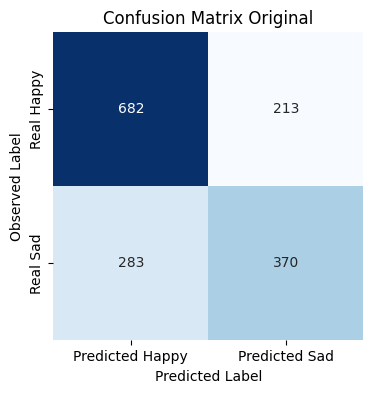

Precision: 0.6346
Recall: 0.5666
Accuracy: 0.6796
F1 score: 0.5987


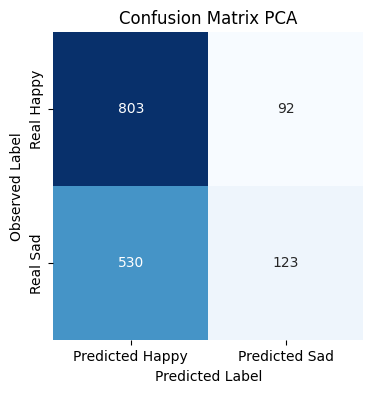

Precision: 0.5721
Recall: 0.1884
Accuracy: 0.5982
F1 score: 0.2834


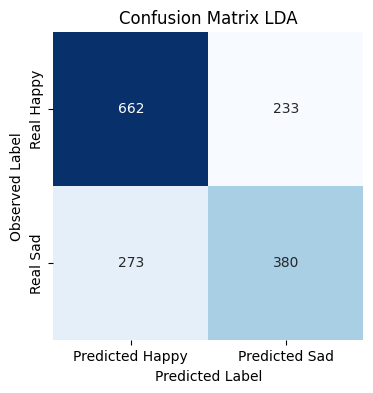

Precision: 0.6199
Recall: 0.5819
Accuracy: 0.6731
F1 score: 0.6003


In [58]:
# Describe confusion matrix for train
m1 = describe_binary_confusion_matrix(model=binary_logistic_original, X_train=X_test_binary_scaled, y_train=y_binary_test, title='Original')
m2 = describe_binary_confusion_matrix(model=binary_logistic_pca, X_train=X_test_binary_pca, y_train=y_binary_test, title='PCA')
m3 = describe_binary_confusion_matrix(model=binary_logistic_lda, X_train=X_test_binary_lda, y_train=y_binary_test, title='LDA')

[2 Marks] e. Apply a Support Vector Machine to classify the faces as happy or sad. Choose parameters / arguments to try to maximize your accuracy. Report the accuracy.

In [27]:
def train_svm(X_train: np.array, X_test: np.array, y_train: np.array, y_test: np.array) -> float:
    """
    Create a Naive Bayes model
    ---
    Args:
    ...
        X_train:  training data
        X_test: np.array - testing data
        y_train: np.array - training labels
        y_test: np.array - testing labels
    """

    param_grid = {
        'C': [0.1, 1],
        'gamma': ['scale', 0.01, 0.1, 1],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    }

    #return train_model(GridSearchCV(SVC(), param_grid, cv=4, scoring='accuracy', n_jobs=-1), X_train, X_test, y_train, y_test)
    return train_model(SVC(), X_train, X_test, y_train, y_test)


In [28]:
# Scaled (Original)
print("Original")
binary_svm_original, acc = train_svm(X_train_binary_scaled, X_test_binary_scaled, y_binary_train, y_binary_test)

# PCA
print("\nPCA")
binary_svm_pca, acc = train_svm(X_train_binary_pca, X_test_binary_pca, y_binary_train, y_binary_test)

# LDA
print("\nLDA")
binary_svm_lda, acc = train_svm(X_train_binary_lda, X_test_binary_lda, y_binary_train, y_binary_test)

Original
Train accuracy: 87.24%
Test accuracy: 74.48%

PCA
Train accuracy: 61.65%
Test accuracy: 59.63%

LDA
Train accuracy: 79.19%
Test accuracy: 67.12%


- The SVM model had an accuracy of 74.48%, becoming the best among the models tested. This can be explained due to how SVM machine works. This model relies on the whole data to build the decision boundaries, and it can even find complex decision boundaries. This characteristic was a better approach than previous models.

- On the other hand, we saw worse performance when applying the feature reduction techniques. This indicates that reducing dimensions for a model capable of capturing complex relationships and can do well in high-dimensionality scenarios could be detrimental to the performance as we saw in this experiment.

In [59]:
# Describe confusion matrix for train
m1 = describe_binary_confusion_matrix(model=binary_svm_original, X_train=X_test_binary_scaled, y_train=y_binary_test, title='Original')
m2 = describe_binary_confusion_matrix(model=binary_svm_pca, X_train=X_test_binary_pca, y_train=y_binary_test, title='PCA')
m3 = describe_binary_confusion_matrix(model=binary_svm_lda, X_train=X_test_binary_lda, y_train=y_binary_test, title='LDA')

In [30]:
# Load the best model for the binary classification that has also the parameter Probability=True
binary_svm_original_probability = None
if train_svm_models:
    binary_svm_original_probability, acc = train_svm(X_train_binary_scaled, X_test_binary_scaled, y_binary_train, y_binary_test)
    if train_svm_models:
        joblib.dump(binary_svm_original_probability, 'binary_svm_original.pkl')
else:
    binary_svm_original_probability = joblib.load('binary_svm_original.pkl')

[1 Mark] f. Which of the approaches above allow you to reliably determine the degree of happiness or sadness (i.e. how happy or how sad)? Which do you trust the most?

According to the accuracy of the models, the best is SVM because it has the highest accuracy and in this case we need to get the proportion of correct predictions.

[2 Marks] g. Based on your answer to f. show the 5 happiest faces and the 5 saddest faces.

In [31]:
# Get scores for test data
binary_scores = binary_svm_original_probability.best_estimator_.decision_function(X_test_binary_scaled)
binary_scores[:5]

array([-1.13629455,  1.01449936,  0.24080313,  1.15407575, -0.36647174])

In [32]:
# Predict the values for the test set
y_binay_pred = binary_svm_original_probability.best_estimator_.predict(X_test_binary_scaled)

In [33]:
binnary_probabilities_df = pd.DataFrame({
    'index': range(len(binary_scores)),
    'pred': y_binay_pred,
    'score': binary_scores
})

happiest_faces = binnary_probabilities_df[binnary_probabilities_df["pred"] == 1].sort_values(by='score', ascending=False).head(5).index
saddest_faces = binnary_probabilities_df[binnary_probabilities_df["pred"] == 0].sort_values(by='score', ascending=False).head(5).index

Happiest

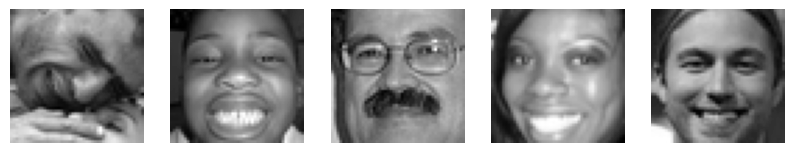

In [34]:
fig, axs = plt.subplots(1, 5, figsize=(5 * 2, 2))
for ax, index in zip(axs, happiest_faces):
    image_data = df_binary_test.iloc[index, :n_inputs].to_numpy();
    img = image_data.reshape(48, 48)
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.show()

Saddest faces

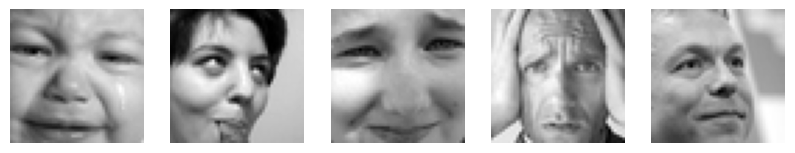

In [35]:
fig, axs = plt.subplots(1, 5, figsize=(5 * 2, 2))
for ax, index in zip(axs, saddest_faces):
    image_data = df_binary_test.iloc[index, :n_inputs].to_numpy();
    img = image_data.reshape(48, 48)
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.show()

# Part II : Multi-class

## For this part you will repeat the tasks in Part I, but instead consider the multi-class problem and classify inputs according to all 7 classes. 

In [36]:
def create_multiclass_classification_dataframe(dataset):
    """
    Create a datafrane from the dataset
    """

    X_df = pd.DataFrame(dataset[:, :n_inputs])
    y_df = pd.DataFrame(dataset[:, n_inputs:n_inputs + n_classes], columns=emotion_columns)
    df = pd.concat([X_df, y_df], axis=1)
    df['emotion'] = y_df.apply(lambda row: get_emotion(row.to_numpy()), axis=1)
    df['emotion'] = df['emotion'].map(multiclass_emotions)

    return df

# Create the dataframes for training and testing
df_multiclass_train = create_multiclass_classification_dataframe(trainingset)
df_multiclass_test = create_multiclass_classification_dataframe(testingset)

df_multiclass_train.head()

0      1      2      3      4      5      6      7      8      9  ...  \
0   70.0   80.0   82.0   72.0   58.0   58.0   60.0   63.0   54.0   58.0  ...   
1  151.0  150.0  147.0  155.0  148.0  133.0  111.0  140.0  170.0  174.0  ...   
2  231.0  212.0  156.0  164.0  174.0  138.0  161.0  173.0  182.0  200.0  ...   
3   24.0   32.0   36.0   30.0   32.0   23.0   19.0   20.0   30.0   41.0  ...   
4    4.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   

    2302   2303  angry  disgust  fear  happy  sad  surprise  neutral  emotion  
0  109.0   82.0    1.0      0.0   0.0    0.0  0.0       0.0      0.0        0  
1  183.0  184.0    1.0      0.0   0.0    0.0  0.0       0.0      0.0        0  
2  110.0  152.0    0.0      0.0   1.0    0.0  0.0       0.0      0.0        2  
3  143.0  142.0    0.0      0.0   0.0    0.0  1.0       0.0      0.0        4  
4   29.0   30.0    0.0      0.0   0.0    0.0  0.0       0.0      1.0        6  

[5 rows x 2312 columns]

In [37]:
# Check if the target variable is balanced
print("Train target variable distribution:")
multiclass_distribution_df = df_multiclass_train['emotion'].value_counts().reset_index()
multiclass_distribution_df['emotion'] = multiclass_distribution_df['emotion'].map(multiclass_emotions_inverse)
multiclass_distribution_df

Train target variable distribution:


emotion  count
0     happy   7215
1   neutral   4965
2       sad   4830
3      fear   4097
4     angry   3995
5  surprise   3171
6   disgust    436

In [38]:
# Scale the data
X_multiclass_train_scaled, X_multiclass_test_scaled = scale_dataframe(
    df_multiclass_train.drop(columns=emotion_columns),
    df_multiclass_test.drop(columns=emotion_columns)
)
X_multiclass_train_scaled[:5]

array([[-0.60988232, -0.45922179, -0.40324932, ..., -0.08629621,
        -0.05737476, -0.41127695],
       [ 0.37236201,  0.40461631,  0.41101767, ...,  1.0387427 ,
         0.89140538,  0.88666892],
       [ 1.34247986,  1.16973007,  0.52376233, ..., -0.31906288,
        -0.04455341,  0.47947022],
       [-1.16770008, -1.05156793, -0.9794998 , ...,  0.37923713,
         0.37855125,  0.35222062],
       [-1.41022954, -1.44646535, -1.43047844, ..., -1.06908883,
        -1.08308302, -1.07297485]])

In [39]:
y_multiclass_train = df_multiclass_train['emotion']
y_multiclass_test = df_multiclass_test['emotion']
y_multiclass_train.shape, y_multiclass_test.shape

((28709,), (3589,))

[4 Marks] a. Apply PCA and LDA to represent the faces, display a sample of a few faces for each case. Produce a plot for PCA showing the cumulative variance captured by adding additional principal components (e.g. 1st PC, 1st + 2nd PC, etc.). On the same figure, plot the same curve for only happy and sad faces used in part 1.

PCA

In [40]:
X_multiclass_train_scaled.shape, y_multiclass_train.shape

((28709, 2304), (28709,))

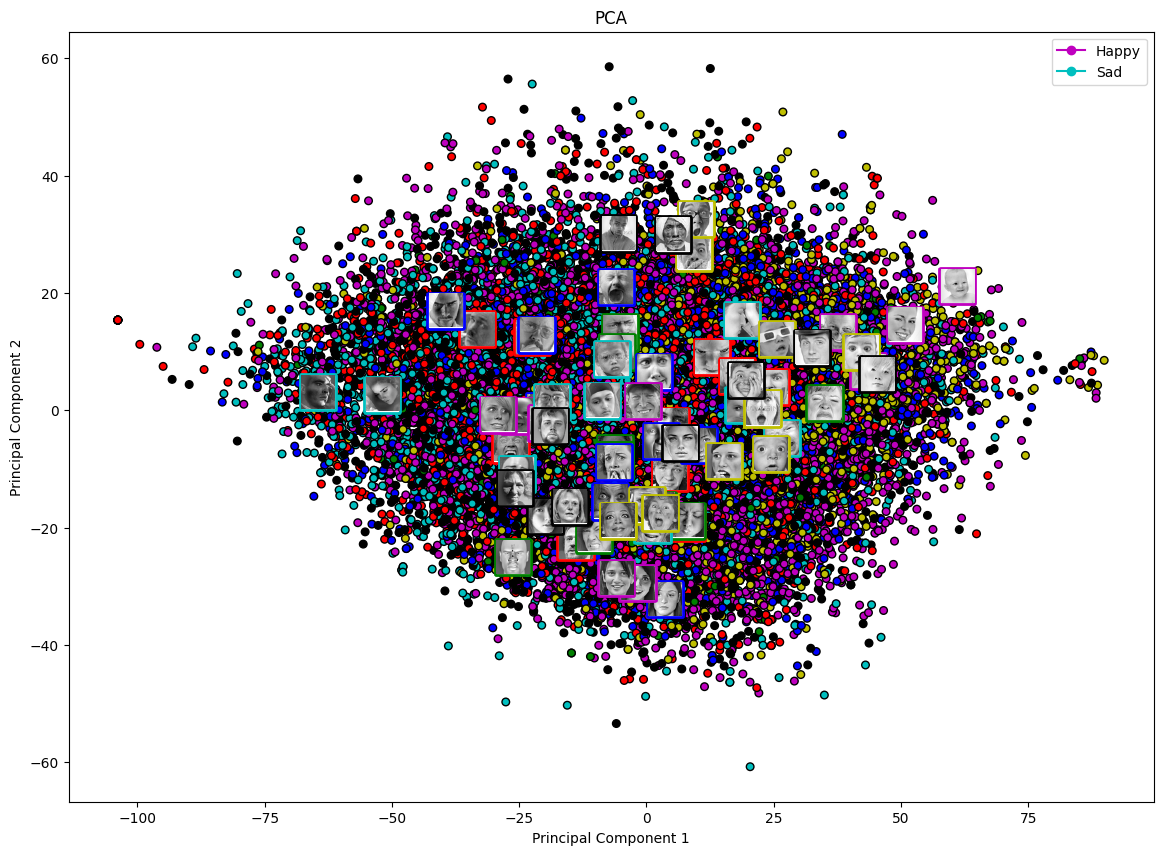

In [41]:
multiclass_pca_2_components = create_pca_2d(X_multiclass_train_scaled, y_multiclass_train.to_numpy(), 2, True)

LDA

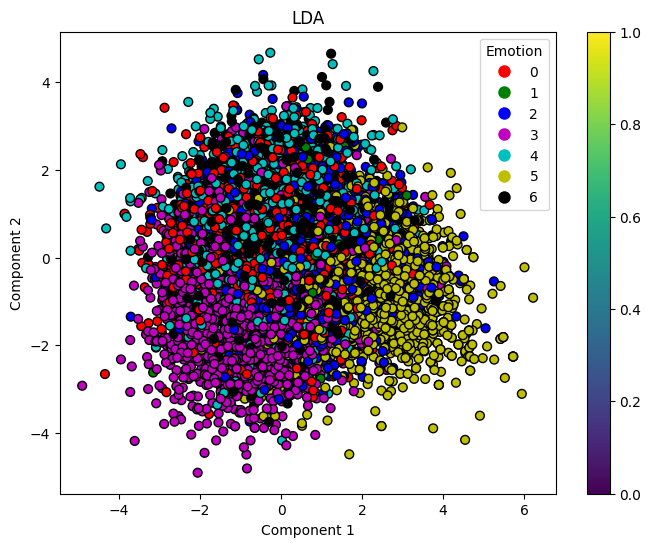

In [42]:
def create_multiclass_lda_2d(X_train: np.array, y_df: pd.DataFrame)-> None:

    lda = LDA(n_components=2)

    # Transform the scaled data using LDA
    X_lda = lda.fit_transform(X_train, y_df.to_numpy())
    
    # Create the legend for the different emotions
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=emotion) for emotion, color in emotion_color_map.items()]

    x = X_lda[:, 0],  # Component 1
    y = X_lda[:, 1],  # Component 2
    c = y_df.map(emotion_color_map).values

    # Visualize the LDA result
    plt.figure(figsize=(8, 6))
    plt.scatter(x=x, y=y, c=c, cmap='viridis', edgecolor='k', s=40)
    plt.title('LDA')
    plt.colorbar()
    plt.legend(handles=handles, title="Emotion")
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

create_multiclass_lda_2d(X_multiclass_train_scaled, df_multiclass_train['emotion'])

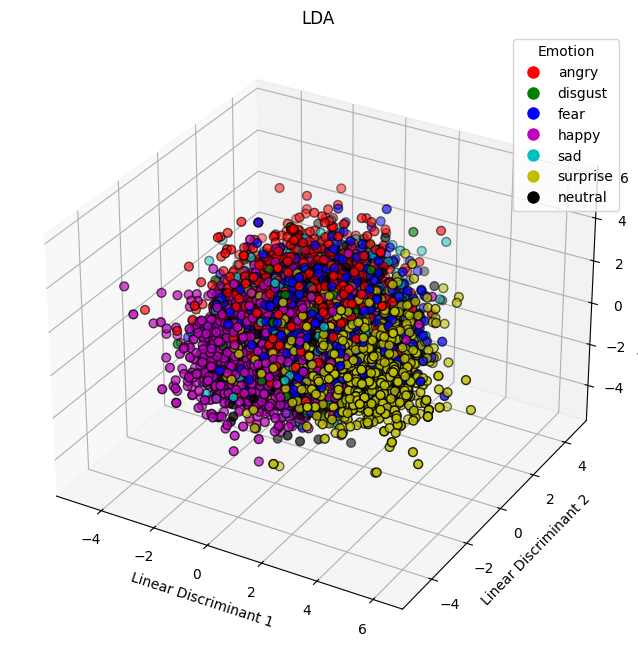

In [54]:
def create_multiclass_lda_3d(X_train: np.array, y_df: pd.DataFrame, colors_map) -> None:

    lda = LDA(n_components=3)
    X_mc_lda = lda.fit_transform(X_train, y_df.to_numpy())

    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=emotion) 
            for emotion, color in emotion_color_map.items()]

    c = y_df.map(colors_map).values

    # Visualize the LDA result
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    sc = ax.scatter(
        X_mc_lda[:, 0],  # Component 1
        X_mc_lda[:, 1],  # Component 2
        X_mc_lda[:, 2],  # Component 3
        c=c,
        edgecolor='k',
        s=40
    )
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=multiclass_emotions_inverse[emotion]) for emotion, color in emotion_color_map.items()]

    ax.legend(handles=handles, title="Emotion")
    ax.set_title('LDA')
    ax.set_xlabel('Linear Discriminant 1')
    ax.set_ylabel('Linear Discriminant 2')
    ax.set_zlabel('Linear Discriminant 3')
    plt.show()

create_multiclass_lda_3d(X_multiclass_train_scaled, df_multiclass_train['emotion'], emotion_color_map)

In [56]:
def create_multiclass_lda_3d_dinamyc(X_train: np.array, y_df: pd.DataFrame, colors_map)-> None:

    lda = LDA(n_components=3)
    X_mc_lda = lda.fit_transform(X_train, y_df.to_numpy())
    
    df_lda = pd.DataFrame(X_mc_lda, columns=['LD1', 'LD2', 'LD3'])
    df_lda['emotion'] = y_df.map(colors_map).values

    fig = px.scatter_3d(
        df_lda,
        x='LD1',
        y='LD2',
        z='LD3',
        color='emotion',
        color_discrete_map=colors_map,
        title='LDA with 3 components',
        labels={
            'LD1': 'Linear Discriminant 1',
            'LD2': 'Linear Discriminant 2',
            'LD3': 'Linear Discriminant 3'
        },
        size=[3] * len(df_lda),
        size_max=10
    )
    fig.update_layout(width=800, height=800)
    fig.show()

create_multiclass_lda_3d_dinamyc(X_multiclass_train_scaled, df_multiclass_train['emotion'], emotion_color_map)

[2 Marks] b. Classify the faces using Naive Bayes and report your accuracy.

In [45]:
multiclass_naive_bayes_model, acc = train_naive_bayes(X_multiclass_train_scaled, X_multiclass_test_scaled, y_multiclass_train, y_multiclass_test)

Train accuracy: 22.24%
Test accuracy: 22.74%


Visualize the results of your classifier on the test set using a confusion matrix. Describe briefly how the multi-class nature of the problem is treated by the classifier.
DESCRIBE BRIEFLY HERE

In [46]:
def describe_multiclass_confusion_matrix(model, X_train: np.array, y_train: np.array):
    """
    Create a confusion matrix
    ---
    Args:
    ...
        model: any - model to train
        X_train:  training data
        y_train: np.array - training labels
        column_names: list - list of column names
    """

    # Predict the class labels
    y_pred = model.predict(X_train)
    
    # If the model provides probabilities, convert them to class labels
    if y_pred.ndim > 1 and y_pred.shape[1] > 1:
        y_pred = y_pred.argmax(axis=1)
    
    cm = confusion_matrix(y_train, y_pred)

    # Convert data to dataframe to plot
    cm_df = pd.DataFrame(cm, index=emotion_columns, columns=emotion_columns)

    # Visualize with seaborn library
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_df, cmap='Blues', fmt='g', annot=True, cbar=False)
    plt.title('Confusion Matrix')
    plt.ylabel('Observed Label')
    plt.xlabel('Predicted Label')
    plt.show()

    rows = []

    # Calculate and print metrics for each class
    for i, label in enumerate(emotion_columns):

        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP
        TN = cm.sum() - (TP + FP + FN)

        # Compute precision
        precision = TP / (TP + FP) if (TP + FP) != 0 else 0
        #print(f"{label} Precision: {precision}")
        #display(Markdown(f"$$\\frac{{TP}}{{TP + FP}} \\rightarrow \\frac{{{TP}}}{{{TP} + {FP}}} \\rightarrow {precision}$$"))

        # Compute recall
        recall = TP / (TP + FN) if (TP + FN) != 0 else 0
        #print(f"{label} Recall: {recall}")
        #display(Markdown(f"$$\\frac{{TP}}{{TP + FN}} \\rightarrow \\frac{{{TP}}}{{{TP} + {FN}}} \\rightarrow {recall}$$"))

        # Compute accuracy
        accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) != 0 else 0
        #print(f"{label} Accuracy: {accuracy}")
        #display(Markdown(f"$$\\frac{{TP + TN}}{{TP + TN + FP + FN}} \\rightarrow \\frac{{{TP} + {TN}}}{{{TP} + {TN} + {FP} + {FN}}} \\rightarrow {accuracy}$$"))

        # Compute F1 score
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
        #print(f"{label} F1 score: {f1}")
        #display(Markdown(f"$$2*\\frac{{Precision * Recall}}{{Precision + Recall}} \\rightarrow \\frac{{{precision} * {recall}}}{{{precision} + {recall}}} \\rightarrow {f1}$$"))

        rows.append({
            'emotion': label,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        })

    # Create a dataframe with the metrics
    df_metrics = pd.DataFrame(rows)
    df_metrics.set_index('emotion', inplace=True)
    df_metrics.index.name = None

    return df_metrics


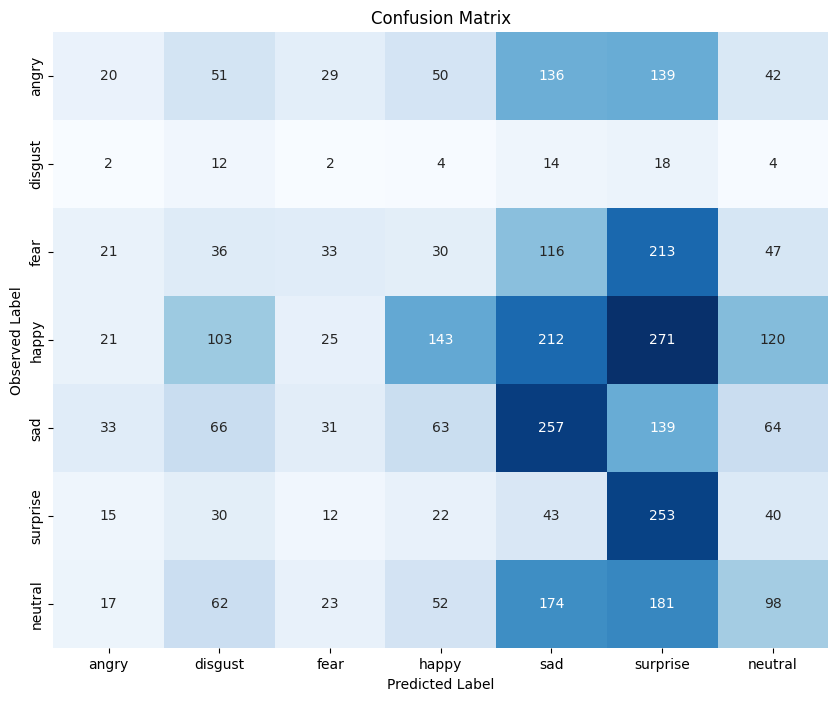

accuracy  precision    recall        f1
angry     0.845082   0.155039  0.042827  0.067114
disgust   0.890777   0.033333  0.214286  0.057692
fear      0.837002   0.212903  0.066532  0.101382
happy     0.728894   0.392857  0.159777  0.227164
sad       0.696016   0.269958  0.393568  0.320249
surprise  0.687099   0.208402  0.609639  0.310620
neutral   0.769852   0.236145  0.161450  0.191781

In [47]:
describe_multiclass_confusion_matrix(multiclass_naive_bayes_model, X_multiclass_test_scaled, y_multiclass_test)

[2 Marks] c. Classify the faces using logistic regression and report your accuracy.

In [48]:
multiclass_logistic_regression_model, acc = train_logistic_regression(X_multiclass_train_scaled, X_multiclass_test_scaled, y_multiclass_train, y_multiclass_test)

Train accuracy: 44.90%
Test accuracy: 36.53%


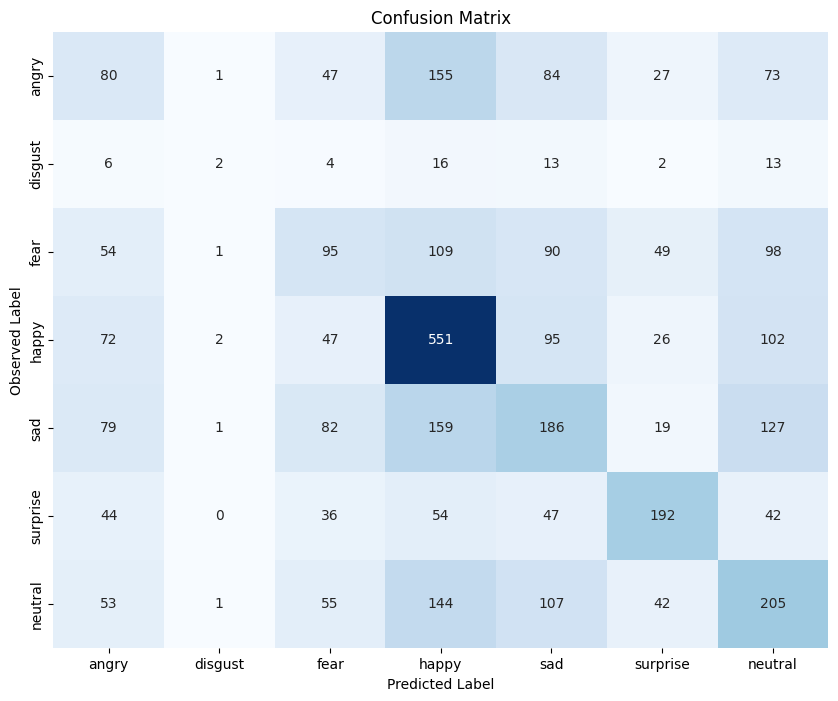

accuracy  precision    recall        f1
angry     0.806353   0.206186  0.171306  0.187135
disgust   0.983282   0.250000  0.035714  0.062500
fear      0.812761   0.259563  0.191532  0.220418
happy     0.726665   0.463805  0.615642  0.529045
sad       0.748398   0.299035  0.284839  0.291765
surprise  0.891892   0.537815  0.462651  0.497409
neutral   0.761215   0.310606  0.337727  0.323599

In [49]:
describe_multiclass_confusion_matrix(multiclass_logistic_regression_model, X_multiclass_test_scaled, y_multiclass_test)

Visualize the results of your classifier on the test set using a confusion matrix. Describe briefly how the multi-class nature of the problem is treated by the classifier.
DESCRIBE BRIEFLY HERE

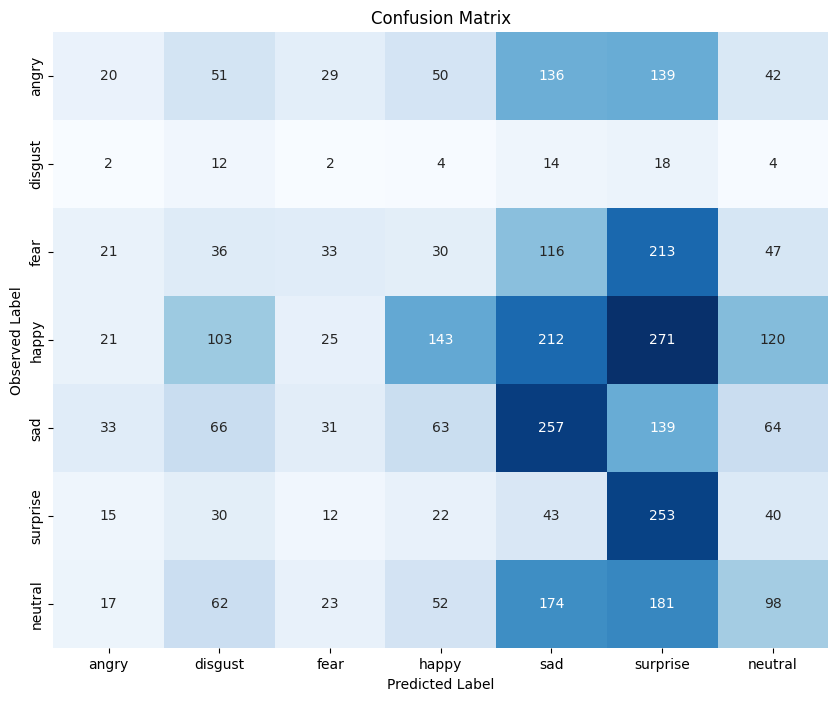

accuracy  precision    recall        f1
angry     0.845082   0.155039  0.042827  0.067114
disgust   0.890777   0.033333  0.214286  0.057692
fear      0.837002   0.212903  0.066532  0.101382
happy     0.728894   0.392857  0.159777  0.227164
sad       0.696016   0.269958  0.393568  0.320249
surprise  0.687099   0.208402  0.609639  0.310620
neutral   0.769852   0.236145  0.161450  0.191781

In [50]:
describe_multiclass_confusion_matrix(multiclass_naive_bayes_model, X_multiclass_test_scaled, y_multiclass_test)

[2 Marks] d. Classify the faces using a support vector machine and report your accuracy.

In [51]:
svm_multiclass_model = None
if train_svm_models:
    svm_multiclass_model, acc = train_svm(X_multiclass_train_scaled, X_multiclass_test_scaled, y_multiclass_train, y_multiclass_test)
    # Save the model
    if train_svm_models:
        joblib.dump(svm_multiclass_model, 'svm_multiclass_model.pkl')
else:
    svm_multiclass_model = joblib.load('svm_multiclass_model.pkl')

Visualize the results of your classifier on the test set using a confusion matrix. Describe briefly how the multi-class nature of the problem is treated by the classifier.
DESCRIBE BRIEFLY HERE

In [53]:
#describe_multiclass_confusion_matrix(svm_multiclass_model, X_multiclass_test_scaled, y_multiclass_test)

[2 Marks] e. Which categories of faces seem to be most similar or least similar?
EXPLAIN HERE

[4 Marks] f. Let's assume that some of the faces were labeled wrong in producing the dataset. Propose and implement a solution that identifies images that are potentially mislabeled. Show 10 samples based on the method you choose.

In [ ]:
# YOUR CODE HERE

# Optional

From all the classification approaches considered above, choose one to score faces based on a continuous valued prediction of for each of the categories.

[No Marks] a. Produce a prediction for each face in the test set (this has 7 dimensions). Visualize these based on a 2D embedding of the scores. The "data points" plotted in the embedding should show the actual picture of the face, at the corresponding 2D point location. (You could consider using t-SNE for your embedding)

In [ ]:
# YOUR CODE HERE

In [ ]:
def compare_incremental_pca():

    data = []
    for i in range(2, 6):
        
        # PCA
        pca = PCA(n_components=i)
        pca.fit_transform(X_multiclass_train_scaled)
        pca_explained_variance_ratio = pca.explained_variance_ratio_

        # LDA
        lda = LDA(n_components=i)
        lda.fit_transform(X_multiclass_train_scaled, y_multiclass_train)
        lda_explained_variance_ratio = lda.explained_variance_ratio_


        data.append({
            "n_components": i,
            "pca": pca_explained_variance_ratio,
            "lda": lda_explained_variance_ratio
        })
    
    print(data)

    # Create the plot
    plt.figure(figsize=(4, 3))
    for entry in data:
        plt.plot(range(1, entry["n_components"] + 1), entry["pca"], marker='o', label=f'PCA n_components={entry["n_components"]}')
        plt.plot(range(1, entry["n_components"] + 1), entry["lda"], marker='x', label=f'LDA n_components={entry["n_components"]}', linestyle='--')
    
    plt.title('PCA and LDA: Cumulative Explained Variance Ratio')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.legend()
    plt.grid(True)
    plt.show()

compare_incremental_pca()

The first component capture about 29% of the variance, the second about 9%, to sum 38% (0.38)